In [2]:
!nvidia-smi

Fri Mar  1 11:44:36 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
import torch
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Mon_Apr__3_17:16:06_PDT_2023
Cuda compilation tools, release 12.1, V12.1.105
Build cuda_12.1.r12.1/compiler.32688072_0
torch:  2.1 ; cuda:  2.1.2


In [4]:
import os
HOME = os.getcwd()
print(HOME)

/kaggle/working


### Installing YOLOv8

In [5]:
!pip install ultralytics

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.1.20 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (4 CPUs, 31.4 GB RAM, 5518.9/8062.4 GB disk)


### Installing Supervision

In [6]:
!pip install supervision==0.7.0

from IPython import display
display.clear_output()

import supervision as sv
print("supervision", sv.__version__)

supervision 0.7.0


### Subway video download

In [7]:
"""%cd {HOME}
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1qZ6ROKdzHbQiHdizKfYbecr9qquOQ0Cz' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1qZ6ROKdzHbQiHdizKfYbecr9qquOQ0Cz" -O subway.mp4 && rm -rf /tmp/cookies.txt"""

'%cd {HOME}\n!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate \'https://docs.google.com/uc?export=download&id=1qZ6ROKdzHbQiHdizKfYbecr9qquOQ0Cz\' -O- | sed -rn \'s/.*confirm=([0-9A-Za-z_]+).*/\x01\n/p\')&id=1qZ6ROKdzHbQiHdizKfYbecr9qquOQ0Cz" -O subway.mp4 && rm -rf /tmp/cookies.txt'

In [8]:
SOURCE_VIDEO_PATH = "/kaggle/input/subway-video-for-object-detection/subway.mp4"

In [9]:
from ultralytics import YOLO

model = YOLO('yolov8s.pt')

100%|██████████| 21.5M/21.5M [00:00<00:00, 156MB/s]


In [10]:
import numpy as np
CLASS_NAMES_DICT = model.model.names
selected_classes = [0]


0: 1280x736 12 persons, 1 dog, 1 backpack, 3 handbags, 1 teddy bear, 30.5ms
Speed: 12.2ms preprocess, 30.5ms inference, 1.9ms postprocess per image at shape (1, 3, 1280, 736)


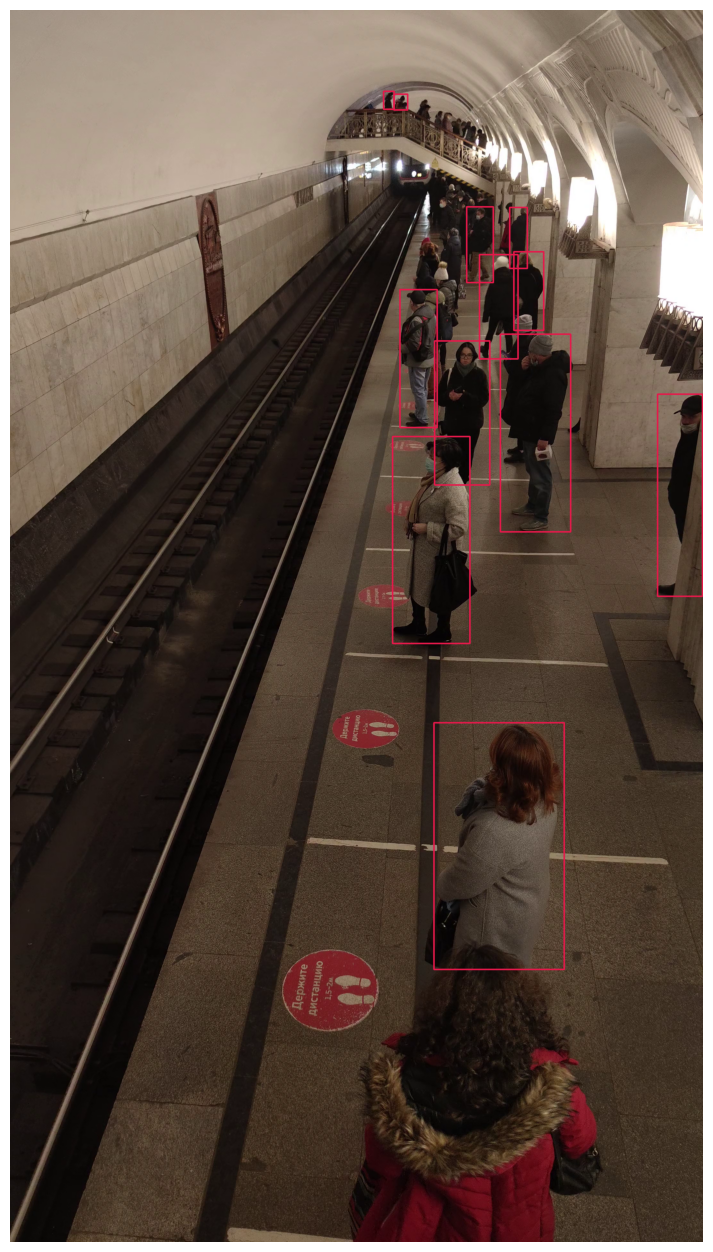

In [13]:
# extract video frame
generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
iterator = iter(generator)
frame = next(iterator)

# detect
results = model(frame, imgsz=1280)[0]
detections = sv.Detections.from_yolov8(results)
detections = detections[np.isin(detections.class_id, selected_classes)]

# annotate
#label_annotator = sv.LabelAnnotator(text_position=sv.Position.TOP)
box_annotator = sv.BoxAnnotator(thickness=4, text_thickness=4, text_scale=2)
labels = [
    f"{CLASS_NAMES_DICT[class_id]} {confidence:0.2f}"
    for confidence, class_id in zip(detections.confidence, detections.class_id)
]
frame = box_annotator.annotate(scene=frame, detections=detections, skip_label=True)

%matplotlib inline
sv.plot_image(frame, (16, 16))


0: 1280x736 12 persons, 1 dog, 1 backpack, 3 handbags, 1 teddy bear, 30.4ms
Speed: 12.0ms preprocess, 30.4ms inference, 2.0ms postprocess per image at shape (1, 3, 1280, 736)


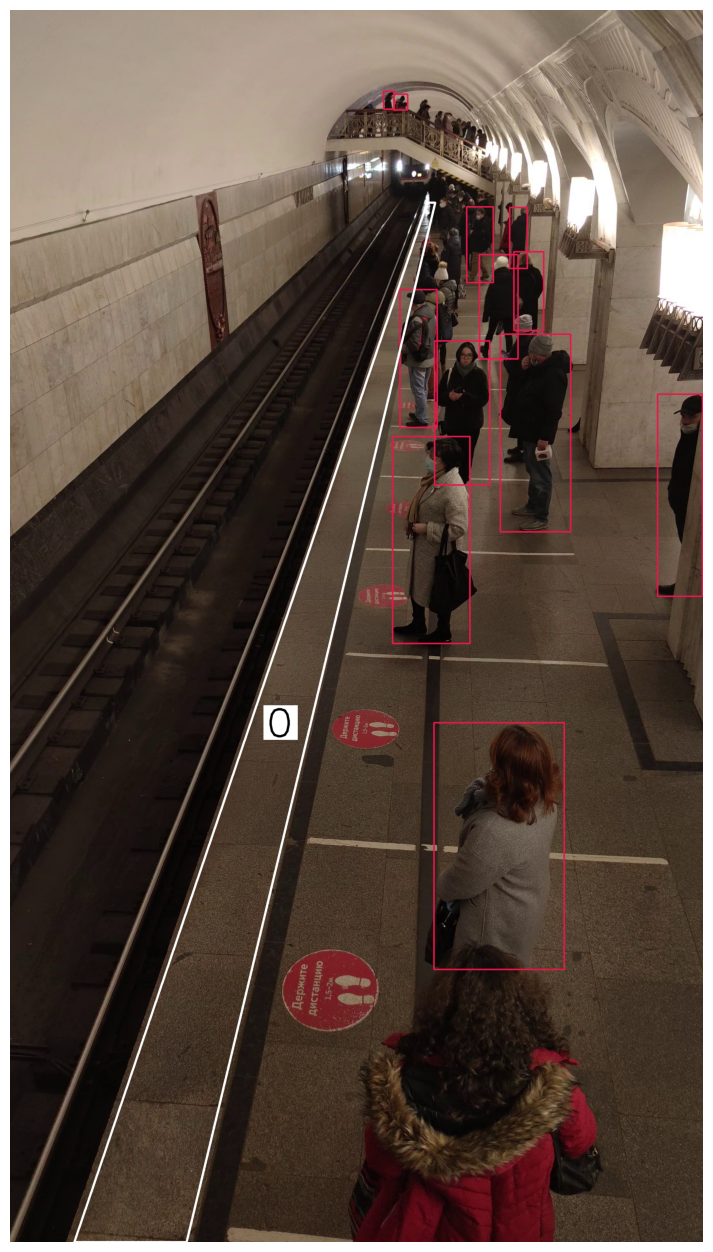

In [16]:
import numpy as np
import supervision as sv

# initiate polygon zone
polygon = np.array([
    [200, 3840],
    [1300, 600],
    [1325, 600],
    [550, 3840]
])
video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
zone = sv.PolygonZone(polygon=polygon, frame_resolution_wh=video_info.resolution_wh)

# initiate annotators
box_annotator = sv.BoxAnnotator(thickness=4, text_thickness=4, text_scale=2)
zone_annotator = sv.PolygonZoneAnnotator(zone=zone, color=sv.Color.white(), thickness=6, text_thickness=6, text_scale=4)

# extract video frame
generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
iterator = iter(generator)
frame = next(iterator)

# detect
results = model(frame, imgsz=1280)[0]
detections = sv.Detections.from_yolov8(results)
detections = detections[np.isin(detections.class_id, selected_classes)]
zone.trigger(detections=detections)

# annotate
box_annotator = sv.BoxAnnotator(thickness=4, text_thickness=4, text_scale=2)
labels = [
    f"{CLASS_NAMES_DICT[class_id]} {confidence:0.2f}"
    for confidence, class_id in zip(detections.confidence, detections.class_id)
]
frame = box_annotator.annotate(scene=frame, detections=detections, skip_label=True)
frame = zone_annotator.annotate(scene=frame)

%matplotlib inline
sv.plot_image(frame, (16, 16))

In [18]:
# initiate polygon zone
polygon = np.array([
    [200, 3840],
    [1300, 600],
    [1325, 600],
    [550, 3840]
])
video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
zone = sv.PolygonZone(polygon=polygon, frame_resolution_wh=video_info.resolution_wh)

# initiate annotators
box_annotator = sv.BoxAnnotator(thickness=4, text_thickness=4, text_scale=2)
zone_annotator = sv.PolygonZoneAnnotator(zone=zone, color=sv.Color.white(), thickness=6, text_thickness=6, text_scale=4)

def process_frame(frame: np.ndarray,_)-> np.ndarray:

    # detect
    results = model(frame, imgsz=1280)[0]
    detections = sv.Detections.from_yolov8(results)
    detections = detections[np.isin(detections.class_id, selected_classes)]
    zone.trigger(detections=detections)

    # annotate
    box_annotator = sv.BoxAnnotator(thickness=4, text_thickness=4, text_scale=2)
    labels = [
        f"{CLASS_NAMES_DICT[class_id]} {confidence:0.2f}"
        for confidence, class_id in zip(detections.confidence, detections.class_id)
    ]
    frame = box_annotator.annotate(scene=frame, detections=detections, labels=labels)
    frame = zone_annotator.annotate(scene=frame)
    return frame
sv.process_video(
    source_path = SOURCE_VIDEO_PATH,
    target_path=f"{HOME}/subway-result.mp4",
    callback = process_frame
)
from IPython import display
display.clear_output()
print("VIDEO PROCESSING COMPLETED")

VIDEO PROCESSING COMPLETED
